In [17]:
import pandas as pd
import numpy as np
import os
import pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
from npc_sessions import DynamicRoutingSession

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [83]:
loadpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\by_session\blockwise_crossval_no_autos'

svc_results={}
decoder_results=os.listdir(loadpath)

In [84]:
#TODO: add session decoder accuracy, add probe, add blockwise decoder accuracy??


# switch_aligned_decoding={
#     'session_id':[],
#     'switch_index':[],
#     'structure':[],
#     'probe':[],
#     'n_units':[],
#     'before_dprime':[],
#     'after_dprime':[],
#     'decision_function_20':[],
#     'decision_function_all':[],
#     'session_decoder_accuracy_20':[],
#     'session_decoder_accuracy_all':[],
# }

decoder_conf_context_switch={}
# loop through n units
unit_nums=np.array([0, 1])
for n_units in unit_nums:
    decoder_conf_context_switch[n_units]={}

    decoder_conf_context_switch[n_units]['structure']=[]
    decoder_conf_context_switch[n_units]['probe']=[]
    decoder_conf_context_switch[n_units]['session']=[]
    decoder_conf_context_switch[n_units]['before_dprime']=[]
    decoder_conf_context_switch[n_units]['after_dprime']=[]
    decoder_conf_context_switch[n_units]['total_units']=[]
    decoder_conf_context_switch[n_units]['switch_index']=[]
    decoder_conf_context_switch[n_units]['session_balanced_accuracy']=[]
    decoder_conf_context_switch[n_units]['session_balanced_accuracy_shuffle']=[]
    decoder_conf_context_switch[n_units]['correct_responses']=[]
    decoder_conf_context_switch[n_units]['decision_function']=[]


#load session
for ii,ff in enumerate(decoder_results[:]):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results=pickle.load(handle)
    print(ff)

    all_areas=np.unique(list(svc_results['block_ids'].keys()))
    timepoints=[0]
    label_list=['vis','aud']
    predict=['block_ids']
    n_units=svc_results['unit_numbers']
    unit_numbers=np.arange(0,len(n_units))
    n_repeats=svc_results['n_repeats']

    #extract decision functions
    
    timebin=0
    predict=['block_ids']
    dec_func={}
    dec_func_shuffle={}

    balanced_accuracy={}
    balanced_accuracy_shuffle={}

    for p in predict:
        dec_func[p]={}
        dec_func_shuffle[p]={}
        balanced_accuracy[p]={}
        balanced_accuracy_shuffle[p]={}
        for n_units in unit_numbers:
            dec_func[p][n_units]={}
            dec_func_shuffle[p][n_units]={}
            balanced_accuracy[p][n_units]={}
            balanced_accuracy_shuffle[p][n_units]={}
            for aa in all_areas:
                if aa in svc_results[p].keys():
                    dec_func[p][n_units][aa]={}
                    dec_func_shuffle[p][n_units][aa]={}
                    balanced_accuracy[p][n_units][aa]={}
                    balanced_accuracy_shuffle[p][n_units][aa]={}
                    if len(svc_results[p][aa][timebin][n_units])>0:
                        dec_func_all=[]
                        dec_func_shuffle_all=[]
                        balanced_accuracy_all=[]
                        balanced_accuracy_shuffle_all=[]
                        for repeat in range(0,n_repeats):
                            dec_func[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['decision_function']
                            dec_func_shuffle[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['shuffle']['decision_function']
                            dec_func_all.append(dec_func[p][n_units][aa][repeat])
                            dec_func_shuffle_all.append(dec_func_shuffle[p][n_units][aa][repeat])

                            balanced_accuracy[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['balanced_accuracy']
                            balanced_accuracy_shuffle[p][n_units][aa][repeat]=svc_results[p][aa][timebin][n_units][repeat]['shuffle']['balanced_accuracy']
                            balanced_accuracy_all.append(balanced_accuracy[p][n_units][aa][repeat])
                            balanced_accuracy_shuffle_all.append(balanced_accuracy_shuffle[p][n_units][aa][repeat])
                        
                        dec_func[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_all),axis=0)
                        dec_func_shuffle[p][n_units][aa]['average']=np.nanmean(np.vstack(dec_func_shuffle_all),axis=0)

                        balanced_accuracy[p][n_units][aa]['average']=np.nanmean(np.vstack(balanced_accuracy_all))
                        balanced_accuracy_shuffle[p][n_units][aa]['average']=np.nanmean(np.vstack(balanced_accuracy_shuffle_all))

    #align results to switch times
    all_areas=np.unique(np.hstack(all_areas))
    unit_numbers=np.arange(0,len(svc_results['unit_numbers']))

    # session_id=svc_results['metadata'].session_id
    session_id=ff[:17]
    print(session_id)


    ### change to trialwise
    ### separate by probe
    ### add session decoder accuracy
    

    #loop through unique areas
    # for aa in all_areas:

    #if has a _probeX, separate by probe
    #save in 'probe', otherwise say None (should maybe change how this works!)

    #get context switch index

    #loop through switches

    #append useful information to switch_aligned_decoding

    #append decision function around the switch to switch_aligned_decoding

    ####copied from decoding_across_context_changes -- modify!
    #load session table 
    session=DynamicRoutingSession(session_id)

    is_correct_response=((session.trials[:]['is_target'] & session.trials[:]['is_response']).values | 
                         (session.trials[:]['is_nontarget'] & ~session.trials[:]['is_response']).values |
                         ((session.trials[:]['stim_name']=='catch') & ~session.trials[:]['is_response']).values)

    # loop through context switches, append
    context_switch_trials=session.trials[:].query('is_context_switch')
    cross_modal_dprime=session.performance[:]['cross_modal_dprime'].values

    trials_before=20
    trials_after=30

    p='block_ids'

    for aa in all_areas:
        for n_units in unit_numbers:
            if aa in dec_func[p][n_units].keys():
                if len(dec_func[p][n_units][aa])>0:
                    temp_dec_func = dec_func[p][n_units][aa]['average']/np.nanstd(dec_func[p][n_units][aa]['average'])
                    
                    for it,(tt,switch_trial) in enumerate(context_switch_trials.iterrows()):
                        # if (cross_modal_dprime[tt]>=dprime_threshold)&(cross_modal_dprime[tt+1]>=dprime_threshold):
                        

                        if 'probe' in aa:
                            probe=aa.split('_')[1]
                            temp_area=aa.split('_')[0]
                        else:
                            probe=None
                            temp_area=aa
                        decoder_conf_context_switch[n_units]['structure'].append(temp_area)
                        decoder_conf_context_switch[n_units]['probe'].append(probe)
                        decoder_conf_context_switch[n_units]['session'].append(session_id)
                        decoder_conf_context_switch[n_units]['before_dprime'].append(cross_modal_dprime[it])
                        decoder_conf_context_switch[n_units]['after_dprime'].append(cross_modal_dprime[it+1])
                        decoder_conf_context_switch[n_units]['total_units'].append(svc_results[p][aa]['n_units'])
                        decoder_conf_context_switch[n_units]['switch_index'].append(it)
                        decoder_conf_context_switch[n_units]['session_balanced_accuracy'].append(balanced_accuracy[p][n_units][aa]['average'])
                        decoder_conf_context_switch[n_units]['session_balanced_accuracy_shuffle'].append(balanced_accuracy_shuffle[p][n_units][aa]['average'])
                        decoder_conf_context_switch[n_units]['correct_responses'].append(is_correct_response[switch_trial['trial_index']-trials_before:
                                                                                                                 switch_trial['trial_index']+trials_after])
                        
                        if switch_trial['context_name']=='vis':
                            decoder_conf_context_switch[n_units]['decision_function'].append(temp_dec_func[switch_trial['trial_index']-trials_before:
                                                                                                               switch_trial['trial_index']+trials_after])
                        elif switch_trial['context_name']=='aud':
                            decoder_conf_context_switch[n_units]['decision_function'].append(-temp_dec_func[switch_trial['trial_index']-trials_before:
                                                                                                                switch_trial['trial_index']+trials_after])


    # bins_before=300
    # bins_after=900
    # p='block_ids'

    # for aa in all_areas:
    #     for tt,rc in enumerate(context_switch_index):

    #         if timebins_table['is_vis_context'].iloc[rc]:
    #             multiplier=-1
    #         elif timebins_table['is_aud_context'].iloc[rc]:
    #             multiplier=1

    #         switch_aligned_decoding['session_id'].append(session.id)
    #         switch_aligned_decoding['structure'].append(aa)
    #         switch_aligned_decoding['n_units'].append(svc_results['block_ids'][aa]['n_units'])
    #         switch_aligned_decoding['before_dprime'].append(cross_modal_dprime[tt])
    #         switch_aligned_decoding['after_dprime'].append(cross_modal_dprime[tt+1])
    #         switch_aligned_decoding['switch_index'].append(tt)

    #         for n_units in unit_numbers:
    #             temp_bin_decoding=(dec_func['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]
    #                         /np.nanstd(dec_func['block_ids'][n_units][aa]['average'][rc-bins_before:rc+bins_after]))*multiplier
    #             dec_func_str='decision_function_'+str(svc_results['unit_numbers'][n_units])
    #             switch_aligned_decoding[dec_func_str].append(temp_bin_decoding)



626791_2022-08-15_0_blockwise_crossval_no_autos.pkl
626791_2022-08-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)


trialSoundArray empty; regenerating sound arrays


aligning sound waveforms: 100%|████████████| 479/479 [01:22<00:00,  5.78trial/s]
No lick time found within response window on sync for trial 145, despite being marked as a response trial.


626791_2022-08-17_0_blockwise_crossval_no_autos.pkl
626791_2022-08-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 512/512 [01:16<00:00,  6.66trial/s]
No lick time found within response window on sync for trial 8, despite being marked as a response trial.


636766_2023-01-23_0_blockwise_crossval_no_autos.pkl
636766_2023-01-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 531/531 [03:08<00:00,  2.82trial/s]
No known opto location data found


636766_2023-01-24_0_blockwise_crossval_no_autos.pkl
636766_2023-01-24


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 533/533 [03:09<00:00,  2.81trial/s]
No known opto location data found


636766_2023-01-25_0_blockwise_crossval_no_autos.pkl
636766_2023-01-25


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 549/549 [03:10<00:00,  2.88trial/s]
No known opto location data found


636766_2023-01-26_0_blockwise_crossval_no_autos.pkl
636766_2023-01-26


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning opto waveforms: 100%|█████████████| 543/543 [03:06<00:00,  2.92trial/s]
No known opto location data found


644864_2023-01-30_0_blockwise_crossval_no_autos.pkl
644864_2023-01-30


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 535/535 [01:31<00:00,  5.84trial/s]
No lick time found within response window on sync for trial 392, despite being marked as a response trial.


644864_2023-01-31_0_blockwise_crossval_no_autos.pkl
644864_2023-01-31


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 515/515 [01:25<00:00,  6.03trial/s]
No lick time found within response window on sync for trial 176, despite being marked as a response trial.


644864_2023-02-01_0_blockwise_crossval_no_autos.pkl
644864_2023-02-01


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 527/527 [01:32<00:00,  5.70trial/s]
No lick time found within response window on sync for trial 84, despite being marked as a response trial.


644864_2023-02-02_0_blockwise_crossval_no_autos.pkl
644864_2023-02-02


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 513/513 [01:27<00:00,  5.89trial/s]


644866_2023-02-07_0_blockwise_crossval_no_autos.pkl
644866_2023-02-07


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms:  90%|██████████▊ | 421/467 [01:14<00:08,  5.61trial/s]Requested range 119253626 to 119268641 on nidaq_channel=1 is out of bounds: nidaq_data.shape=(119186320, 8)
No sound recording for trial 421 aud stim (presentation.trigger_time_on_sync=4151.89958 s) - setting latency=np.nan
No sound recording for trial 422 aud stim (presentation.trigger_time_on_sync=4157.93796 s) - setting latency=np.nan
No sound recording for trial 423 aud stim (presentation.trigger_time_on_sync=4165.3274 s) - setting latency=np.nan
No sound recording for trial 427 aud stim (presentation.trigger_time_on_sync=4190.84857 s) - setting latency=np.nan
No sound recording for trial 428 aud stim (presentation.trigger_time_on_sync=4199.02204 s) - setting latency=np.na

644866_2023-02-09_0_blockwise_crossval_no_autos.pkl
644866_2023-02-09


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 539/539 [01:40<00:00,  5.35trial/s]


644866_2023-02-10_0_blockwise_crossval_no_autos.pkl
644866_2023-02-10


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 528/528 [01:33<00:00,  5.64trial/s]


644867_2023-02-20_0_blockwise_crossval_no_autos.pkl
644867_2023-02-20


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 534/534 [01:34<00:00,  5.64trial/s]


644867_2023-02-22_0_blockwise_crossval_no_autos.pkl
644867_2023-02-22


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 529/529 [01:34<00:00,  5.63trial/s]


644867_2023-02-23_0_blockwise_crossval_no_autos.pkl
644867_2023-02-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 537/537 [01:36<00:00,  5.55trial/s]


649943_2023-02-13_0_blockwise_crossval_no_autos.pkl
649943_2023-02-13


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 524/524 [01:36<00:00,  5.45trial/s]


649943_2023-02-14_0_blockwise_crossval_no_autos.pkl
649943_2023-02-14


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 540/540 [01:41<00:00,  5.34trial/s]


649943_2023-02-15_0_blockwise_crossval_no_autos.pkl
649943_2023-02-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 547/547 [01:40<00:00,  5.43trial/s]


649943_2023-02-16_0_blockwise_crossval_no_autos.pkl
649943_2023-02-16


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 534/534 [01:36<00:00,  5.52trial/s]


660023_2023-08-09_0_blockwise_crossval_no_autos.pkl
660023_2023-08-09


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 501/501 [01:30<00:00,  5.56trial/s]
No lick time found within response window on sync for trial 478, despite being marked as a response trial.


662892_2023-08-21_0_blockwise_crossval_no_autos.pkl
662892_2023-08-21


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 490/490 [01:26<00:00,  5.69trial/s]


662892_2023-08-22_0_blockwise_crossval_no_autos.pkl
662892_2023-08-22


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 522/522 [01:27<00:00,  5.97trial/s]


662892_2023-08-23_0_blockwise_crossval_no_autos.pkl
662892_2023-08-23


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 470/470 [01:22<00:00,  5.73trial/s]
No lick time found within response window on sync for trial 175, despite being marked as a response trial.


662892_2023-08-24_0_blockwise_crossval_no_autos.pkl
662892_2023-08-24


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 476/476 [01:22<00:00,  5.75trial/s]


666986_2023-08-15_0_blockwise_crossval_no_autos.pkl
666986_2023-08-15


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 542/542 [01:33<00:00,  5.81trial/s]


666986_2023-08-16_0_blockwise_crossval_no_autos.pkl
666986_2023-08-16


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 552/552 [01:39<00:00,  5.57trial/s]


666986_2023-08-17_0_blockwise_crossval_no_autos.pkl
666986_2023-08-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 547/547 [01:41<00:00,  5.38trial/s]


667252_2023-09-25_0_blockwise_crossval_no_autos.pkl
667252_2023-09-25
667252_2023-09-28_0_blockwise_crossval_no_autos.pkl
667252_2023-09-28


No lick time found within response window on sync for trial 204, despite being marked as a response trial.
No lick time found within response window on sync for trial 437, despite being marked as a response trial.
No lick time found within response window on sync for trial 461, despite being marked as a response trial.


668755_2023-08-28_0_blockwise_crossval_no_autos.pkl
668755_2023-08-28


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 533/533 [01:28<00:00,  6.04trial/s]


668755_2023-08-29_0_blockwise_crossval_no_autos.pkl
668755_2023-08-29


Session 668755_2023-08-29 has known issues: ['https://github.com/AllenInstitute/npc_lims/issues/15']
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 520/520 [01:33<00:00,  5.58trial/s]


668755_2023-08-30_0_blockwise_crossval_no_autos.pkl
668755_2023-08-30


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
aligning sound waveforms: 100%|████████████| 513/513 [01:19<00:00,  6.46trial/s]


668755_2023-08-31_0_blockwise_crossval_no_autos.pkl
668755_2023-08-31
674562_2023-10-02_0_blockwise_crossval_no_autos.pkl
674562_2023-10-02


No lick time found within response window on sync for trial 333, despite being marked as a response trial.
No lick time found within response window on sync for trial 416, despite being marked as a response trial.


674562_2023-10-03_0_blockwise_crossval_no_autos.pkl
674562_2023-10-03


No lick time found within response window on sync for trial 17, despite being marked as a response trial.
No lick time found within response window on sync for trial 297, despite being marked as a response trial.


674562_2023-10-05_0_blockwise_crossval_no_autos.pkl
674562_2023-10-05
681532_2023-10-16_0_blockwise_crossval_no_autos.pkl
681532_2023-10-16
681532_2023-10-17_0_blockwise_crossval_no_autos.pkl
681532_2023-10-17


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\DynamicRoutingTask\Analysis\DynamicRoutingAnalysisUtils.py:213: RuntimeWarning: invalid value encountered in scalar divide
  self.falseAlarmSameModal.append(self.falseAlarmTrials[sameModal].sum() / sameModal.sum())
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\DynamicRoutingTask\Analysis\DynamicRoutingAnalysisUtils.py:214: RuntimeWarning: invalid value encountered in scalar divide
  self.falseAlarmOtherModalGo.append(self.falseAlarmTrials[otherModalGo].sum() / otherModalGo.sum())
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\DynamicRoutingTask\Analysis\DynamicRoutingAnalysisUtils.py:206: RuntimeWarning: invalid value encountered in scalar divide
  self.catchResponseRate.append(self.catchResponseTrials[blockTrials].sum() / self.catchTrials[blockTrials].sum())
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\DynamicRoutingTask\Analysis\DynamicRoutingAnalysisUtils.py:207: RuntimeWarning: invalid value encountered in scalar divide
  se

681532_2023-10-18_0_blockwise_crossval_no_autos.pkl
681532_2023-10-18


In [ ]:
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\blockwise crossval"

with open(os.path.join(savepath,'blockwise_crossval_no_autos.pkl'),'wb') as handle:
    pickle.dump(decoder_conf_context_switch,handle)

In [45]:
loadpath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\blockwise crossval"

with open(os.path.join(loadpath,'blockwise_crossval_across_sessions.pkl'),'rb') as handle:
    decoder_conf_context_switch=pickle.load(handle)

In [80]:
pd.DataFrame.from_dict(decoder_conf_context_switch[0]).query('structure.str.contains("SCiw")')

,structure,probe,session,before_dprime,after_dprime,total_units,switch_index,session_balanced_accuracy,session_balanced_accuracy_shuffle,correct_responses,decision_function
475,SCiw,None,636766_2023-01-26,2.587278,2.341379,21,0,0.429904,0.496142,"[True, True, True, False, True, True, True, Fa...","[0.6236507140922318, 1.2871134736089416, 0.163..."
476,SCiw,None,636766_2023-01-26,2.341379,1.458783,21,1,0.429904,0.496142,"[True, False, True, True, True, True, True, Fa...","[0.9547391815743631, 0.6507740906642727, 0.896..."
477,SCiw,None,636766_2023-01-26,1.458783,2.623004,21,2,0.429904,0.496142,"[True, True, True, True, True, True, True, Tru...","[-0.3429300231350617, -0.07732464914248738, 0...."
478,SCiw,None,636766_2023-01-26,2.623004,2.054216,21,3,0.429904,0.496142,"[True, True, False, True, True, True, False, T...","[0.8772530402360588, -0.38246444371172583, -1...."
479,SCiw,None,636766_2023-01-26,2.054216,2.149540,21,4,0.429904,0.496142,"[True, True, True, False, True, True, True, Tr...","[-0.28715797162806295, 0.6674101014075725, -0...."
575,SCiw,None,644864_2023-01-30,2.549420,1.458426,23,0,0.104150,0.498432,"[True, False, False, True, True, True, False, ...","[1.1281906537577142, 0.3751590056191445, 0.471..."
576,SCiw,None,644864_2023-01-30,1.458426,1.304292,23,1,0.104150,0.498432,"[False, True, False, True, False, True, True, ...","[0.5977570535003992, 0.08620990750771809, 0.82..."
577,SCiw,None,644864_2023-01-30,1.304292,1.871920,23,2,0.104150,0.498432,"[True, True, True, True, True, True, True, Tru...","[0.6488088996195206, -0.13350786582592894, 0.4..."
578,SCiw,None,644864_2023-01-30,1.871920,1.413531,23,3,0.104150,0.498432,"[True, True, True, True, False, True, True, Tr...","[0.31522039956704606, 0.5404130765064503, 0.56..."
579,SCiw,None,644864_2023-01-30,1.413531,1.774796,23,4,0.104150,0.498432,"[True, False, True, True, True, True, True, Tr...","[0.34391838291318333, 0.6874443010074824, 0.81..."


Text(0, 0.5, 'prev <- normalized context confidence -> current')

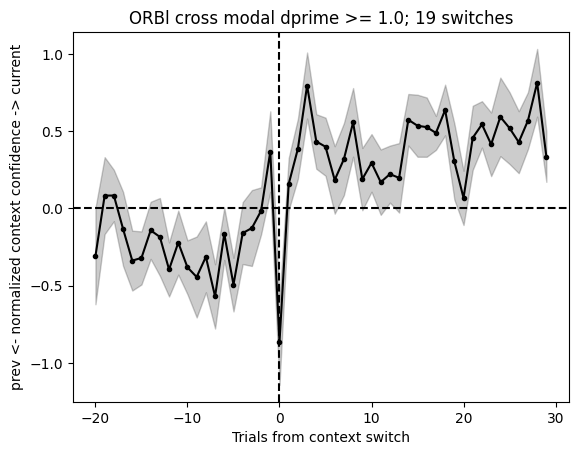

In [82]:

trials_before=20
trials_after=30

sel_area='ORBl'
sel_nunits=1
dprime_min_threshold=1.0
# dprime_max_threshold=5.0

temp_decoder_conf_df=pd.DataFrame.from_dict(decoder_conf_context_switch[sel_nunits]).query('structure==@sel_area')

# row_len=[]
# for rr,row in temp_decoder_conf_df.iterrows():
#     row_len.append(len(row['decision_function']))

decoder_conf_dprime_thresh=temp_decoder_conf_df.query('before_dprime>=@dprime_min_threshold and after_dprime>=@dprime_min_threshold')# and \
                                                       #before_dprime<=@dprime_max_threshold and after_dprime<=@dprime_max_threshold')
decision_function=np.vstack(decoder_conf_dprime_thresh['decision_function'].values)

correct_responses=np.vstack(decoder_conf_dprime_thresh['correct_responses'].values) 
mean_correct_responses=np.nanmean(correct_responses,axis=0)
mean_correct_responses[0:trials_before+1]=-mean_correct_responses[0:trials_before+1]

fig,ax=plt.subplots(1,1)
# ax.plot(np.arange(-trials_before,trials_after),np.vstack(decoder_conf_dprime_thresh['decision_function'].values).T)
ax.plot(np.arange(-trials_before,trials_after),np.nanmean(np.vstack(decision_function),axis=0),'k.-')
ax.fill_between(np.arange(-trials_before,trials_after),
                np.nanmean(np.vstack(decision_function),axis=0)+
                st.sem(np.vstack(decision_function),axis=0),
                np.nanmean(np.vstack(decision_function),axis=0)-
                st.sem(np.vstack(decision_function),axis=0),
                color='k',alpha=0.2)

# ax.plot(np.arange(-trials_before,trials_after),mean_correct_responses,'k--')

ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_title(sel_area+' cross modal dprime >= '+str(dprime_min_threshold)+'; '+str(decision_function.shape[0])+' switches')
ax.set_xlabel('Trials from context switch')
ax.set_ylabel('prev <- normalized context confidence -> current')